In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [13]:
# Load Data from Yahoo Datasets
csv_path = input("Enter the path to your CSV file: ")
def load_stock_data(csv_path):
    data = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')
    print("\nFirst 5 rows of the dataset:\n", data.head())
    print("\nDataset Summary:\n", data.info())
    data['Return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

Enter the path to your CSV file:  stock_details_5_years.csv


In [14]:
# Calculate Financial Indicators
def add_technical_indicators(data):
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    data['Upper_BB'] = data['SMA_20'] + (data['Close'].rolling(window=20).std() * 2)
    data['Lower_BB'] = data['SMA_20'] - (data['Close'].rolling(window=20).std() * 2)
    
    data.dropna(inplace=True)
    return data

In [15]:
# Anomaly Detection with Isolation Forest
def detect_anomalies(data):
    features = ['Close', 'SMA_20', 'EMA_20', 'RSI', 'Upper_BB', 'Lower_BB']
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[features])
    
    model = IsolationForest(contamination=0.01, random_state=42)
    data['Anomaly'] = model.fit_predict(data_scaled)
    data['Anomaly'] = data['Anomaly'].apply(lambda x: 1 if x == -1 else 0)
    
    # Calculate Accuracy (assuming normal data is majority class)
    accuracy = accuracy_score([0] * len(data), data['Anomaly'])
    print(f"Anomaly Detection Model Accuracy: {accuracy * 100:.2f}%")
    return data

In [16]:
# Anomalies Visualization
def plot_anomalies(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.scatter(data.index[data['Anomaly'] == 1], data['Close'][data['Anomaly'] == 1], color='red', label='Anomaly')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f'Anomalies in {title} Stock Price')
    plt.legend()
    plt.show()

In [17]:
# Indicators Visualization
def plot_indicators(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['SMA_20'], label='SMA 20', color='green')
    plt.plot(data.index, data['EMA_20'], label='EMA 20', color='orange')
    plt.fill_between(data.index, data['Upper_BB'], data['Lower_BB'], color='gray', alpha=0.3, label='Bollinger Bands')
    plt.legend()
    plt.title('Financial Indicators')
    plt.show()


First 5 rows of the dataset:
                                  Open        High         Low       Close  \
Date                                                                        
2018-11-29 00:00:00-05:00   43.829761   43.863354   42.639594   43.083508   
2018-11-29 00:00:00-05:00  104.769074  105.519257  103.534595  104.636131   
2018-11-29 00:00:00-05:00   54.176498   55.007500   54.099998   54.729000   
2018-11-29 00:00:00-05:00   83.749496   84.499496   82.616501   83.678497   
2018-11-29 00:00:00-05:00   39.692784   40.064904   38.735195   39.037853   

                              Volume  Dividends  Stock Splits Company  
Date                                                                   
2018-11-29 00:00:00-05:00  167080000       0.00           0.0    AAPL  
2018-11-29 00:00:00-05:00   28123200       0.00           0.0    MSFT  
2018-11-29 00:00:00-05:00   31004000       0.00           0.0   GOOGL  
2018-11-29 00:00:00-05:00  132264000       0.00           0.0    AMZN

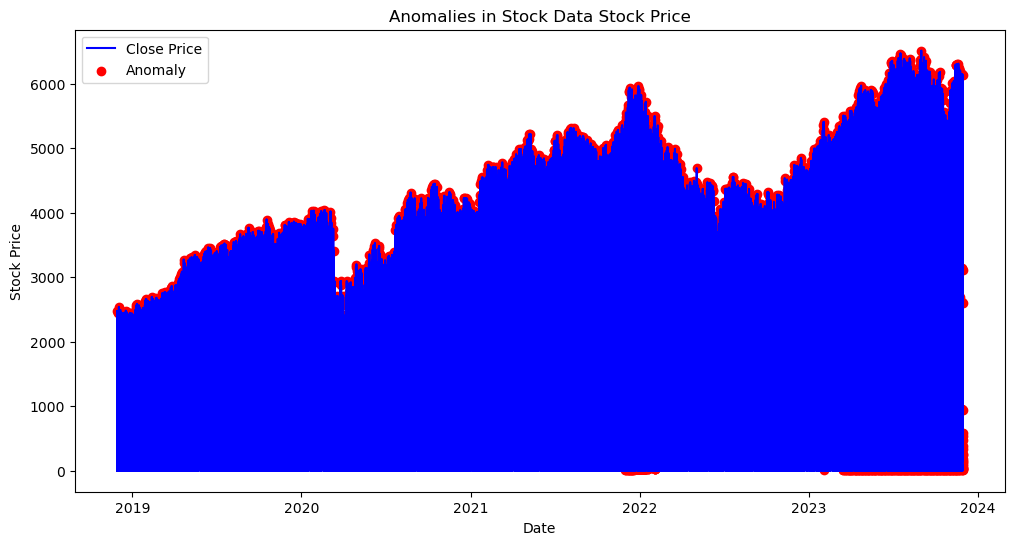

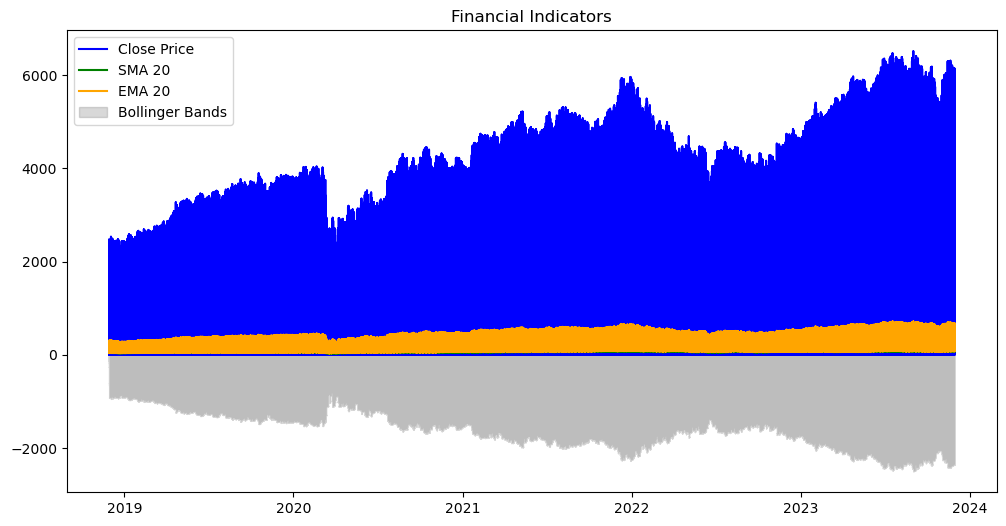

In [18]:
# Running the pipeline
data = load_stock_data(csv_path)
data = add_technical_indicators(data)
data = detect_anomalies(data)
plot_anomalies(data, "Stock Data")
plot_indicators(data)